# Reverse-engineering the API

The only place I was able to find a comprehensive dataset on gins is stuck behind an iOS/Android app's private API. The following is a high level description of how I accessed the base URL, API structure and API key.
- The simplest way to approach the problem is to use an Android emulator, in this case I used Android Studio. Another option would be to use mitmproxy, but due to Android's strict Certificate Authority management it is a bit finicky to setup with a system certificate on an Android emulator.
- I downloaded the target app APK, and installed it on the emulted device.
- Installed ADB, and made sure to add the platform-tools folder to your PATH variable.
- Installed HTTP Toolkit. Selected Android device via ADB as my traffic source and followed setup steps in the emulator.
- Done! Now I can see HTTP requests coming in from the emulator.
- All there is left to do is find the GET request that I am after, I have done this by clicking on a new item on the main page of the application. The resulting API key and structure is what I use in my code.


In [28]:
import configparser
import requests
import time
import json
import os
import boto3
import pandas as pd
import numpy as np
from requests.exceptions import HTTPError
import sql_statements
import aws_helper_functions

# Variables
config = configparser.ConfigParser()
config.read('config.cfg')

baseURL = config.get("REQUESTS", "baseURL")
api_key = config.get("REQUESTS", "api_key")
headers = {
    'User-Agent': config.get("REQUESTS", "headers_user_agent"),
    'From': config.get("REQUESTS", "headers_from")
}

raw_folder = config.get("FOLDER", "raw_folder")
normalized_folder = config.get("FOLDER", "normalized_folder")

#Identifiers & Credentials
DB_NAME=config.get("CLUSTER", "DB_NAME")
CLUSTER_ID=config.get("CLUSTER", "CLUSTER_ID")
DB_USER=config.get("CLUSTER", "DB_USER")
DB_PASSWORD=config.get("CLUSTER", "DB_PASSWORD")
CLUSTER_TYPE=config.get("CLUSTER", "CLUSTER_TYPE")
NODE_TYPE=config.get("CLUSTER", "NODE_TYPE")
NUMBER_OF_NODES=config.get("CLUSTER", "NUMBER_OF_NODES")
DB_PORT=config.get("CLUSTER", "DB_PORT")

ROLE_NAME = config.get("IAM_ROLE", "ROLE_NAME")
KEY = config.get("AWS", "KEY")
SECRET = config.get("AWS", "SECRET")
REGION = config.get("AWS", "REGION")

s3_client = boto3.client("s3",
                       region_name=REGION,
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                    )
redshift = boto3.client('redshift',
                       region_name=REGION,
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                    )
iam = boto3.client('iam',
                       region_name=REGION,
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                    )
ec2 = boto3.resource('ec2',
                       region_name=REGION,
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                    )
redshift_data = boto3.client('redshift-data',
                       region_name=REGION,
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                    )

# Pull the data from API

In [ ]:
# Run this cell if you want to run the scraper(~50 minutes), or skip and use the local file in the next cell instead.

'''
Get highest ID number from ginventory_short.json
A version of the dataset is available from one of the first calls the app makes when establishing connection,
with a reduced set of columns. The largest id num (8770) comes from this file (ginventory_short.json).
'''
with open('/'.join([raw_folder, 'ginventory_short.json']), 'r', encoding='utf-8') as file:
    file_json = json.load(file)

df = pd.DataFrame(file_json)
df['id'] = df['id'].apply(pd.to_numeric)
largest_id = df.sort_values('id', ascending=False).head(1)
largest_id = largest_id.iloc[0,0]
print(largest_id)


'''
Looping through all the requests, save responses to local and S3
Collecting all the information from the API takes ~ 50 minutes!
'''
response_collection = []
for i in range(1,largest_id+1):
    url = baseURL.format(i, api_key)
    try:
        response = requests.get(url, headers = headers)
        response.raise_for_status()
        print(i)
        response_collection.append(response.json())
        time.sleep(0.1)
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')
    else:
        print('Success!')
    
with open('/'.join([raw_folder, 'data_full.json']), 'w', encoding='utf-8') as f:
    json.dump(response_collection, f, ensure_ascii=False, indent=4)
print("Responses collected!")

# Upload raw file to s3
s3_client.upload_file('/'.join([raw_folder, 'data_full.json']), "ginventory-bucket", '/'.join([raw_folder, 'data_full.json']))

In [29]:
# Read from local file
with open('/'.join([raw_folder, 'data_full.json']), 'r', encoding='utf-8') as file:
    file_json = json.load(file)

# Data quality issues

- Country and abv columns had cases where 2 values were included, seperated by /.
- Columns that should be integer have been cast as such.
- Country names did not always match ISO standards, in such cases the country name was replaced.

## Data cleaning

In [30]:
df = pd.json_normalize(file_json)
# Dropping columns with relationship data. This will be processed in another cell.
df = df.drop(['direct_purchase_url', 'user_rating', 'in_wishlist', 'in_cabinet', 'purchase_links.data',
              'perfect_tonics.data','perfect_garnishes.data', 'perfect_gins.data', 'description.content', 
              'description.google_translation', 'description.original_content'], axis=1)


# Correct abv values where format is ##/##, first number is taken
df['abv'] = np.where(df["abv"].str.contains("/", na=False), df['abv'].str.split('/').str.get(0).str.strip(), df['abv'])

# Correct values with % in them, change commas to dots
df['abv'] = df['abv'].replace('%','', regex=True).replace(',','.', regex=True)

# Handling numeric columns to adhere to correct data types in downstream pipeline
df['abv'] = pd.to_numeric(arg=df['abv'] ,errors='coerce')
df['average_rating'] = df['average_rating'].apply(pd.to_numeric)

# Fill NA with 0, so we can downcast all values to integer
df['rating_count'] = df['rating_count'].fillna(0)
df['rating_count'] = pd.to_numeric(arg=df['rating_count'],downcast='integer')

# Correcting country column.
# Handling the case where country format = country / country (eg.: Switzerland / United States)
df['country'] = np.where(df['country'].str.contains('/', na=False), df['country'].str.split('/').str.get(0).str.strip(), df['country'])

# Country names that do not adhere to ISO country naming standards are replaced
country_corrections = {
    'Vietnam': 'Viet Nam',
    'Russia' : 'Russian Federation',
    'Taiwan' : 'Taiwan, Province of China',
    'U.S. Virgin Islands' : 'Virgin Islands, U.s.',
    'Hong Kong SAR China' : 'Hong Kong',
    'Unknown or Invalid Region' : None,
    '' : None,
    }

for i in country_corrections:
    df['country'] = np.where(df.country == i, country_corrections[i], df['country'])

df['country'] = np.where(df.producer == 'Little Brown Dog Spirits', 'United Kingdom', df['country'])

df_garnish = df[df.type == 'garnish']
df_garnish = df_garnish[['id', 'type', 'name']]

# We drop the remaining rows without valid country values.
df = df[df.country.isna()==False]

df_gin = df[df.type == 'gin']
df_tonic = df[df.type == 'tonic']

## Save normalized tables to local and S3

In [31]:
os.makedirs(normalized_folder, exist_ok=True)
df_gin.to_csv('/'.join([normalized_folder, 'gins.csv']), sep=';', index=False)
df_garnish.to_csv('/'.join([normalized_folder, 'garnishes.csv']), sep=';', index=False)
df_tonic.to_csv('/'.join([normalized_folder, 'tonics.csv']), sep=';', index=False)

s3_client.upload_file('/'.join([normalized_folder, 'gins.csv']), "ginventory-bucket", '/'.join([normalized_folder, 'gins.csv']))
s3_client.upload_file('/'.join([normalized_folder, 'garnishes.csv']), "ginventory-bucket", '/'.join([normalized_folder, 'garnishes.csv']))
s3_client.upload_file('/'.join([normalized_folder, 'tonics.csv']), "ginventory-bucket", '/'.join([normalized_folder, 'tonics.csv']))


## Extract relationships between gins, garnishes and tonics

In [51]:
# These tables will form our many-to-many translation tables in our model

df = pd.DataFrame(file_json)
df = df[df.type == 'gin']

# Prepare dataframe with the gin->perfect tonic relationship
df["perfect_tonics"] = df["perfect_tonics"].str["data"]
df_perfect_tonics = df.explode("perfect_tonics")
df_perfect_tonics = pd.concat(
    [
        df_perfect_tonics,
        df_perfect_tonics.pop("perfect_tonics").apply(pd.Series).add_prefix("perfect_tonics_"),
    ], axis=1)

# Select the necessary columns, drop NA, change data types
df_perfect_tonics = df_perfect_tonics[['id', 'perfect_tonics_id']]
df_perfect_tonics.dropna(inplace = True)
df_perfect_tonics = df_perfect_tonics.astype(int)

# Save
df_perfect_tonics.to_csv('/'.join([normalized_folder, 'perfect_tonics.csv']), sep=';', index=False)
s3_client.upload_file('/'.join([normalized_folder, 'perfect_tonics.csv']), "ginventory-bucket", '/'.join([normalized_folder, 'perfect_tonics.csv']))

# Prepare dataframe with the gin->perfect garnish relationship
df["perfect_garnishes"] = df["perfect_garnishes"].str["data"]
df_perfect_garnishes = df.explode("perfect_garnishes")
df_perfect_garnishes = pd.concat(
    [
        df_perfect_garnishes,
        df_perfect_garnishes.pop("perfect_garnishes")
        .apply(pd.Series)
        .add_prefix("perfect_garnishes_"),
    ], axis=1)

# Select the necessary columns, drop NA, change data types
df_perfect_garnishes = df_perfect_garnishes[['id', 'perfect_garnishes_id']]
df_perfect_garnishes.dropna(inplace = True)
df_perfect_garnishes = df_perfect_garnishes.astype(int)

# Save
df_perfect_garnishes.to_csv('/'.join([normalized_folder, 'perfect_garnishes.csv']), sep=';', index=False)
s3_client.upload_file('/'.join([normalized_folder, 'perfect_garnishes.csv']), "ginventory-bucket", '/'
.join([normalized_folder, 'perfect_garnishes.csv']))

# Exploring our main dataset


In [33]:
print(f'Total number of gins in our dataset: {df_gin.id.count()}')
print(f'Total number of garnishes in our dataset: {df_garnish.id.count()}')
print(f'Total number of tonics in our dataset: {df_tonic.id.count()}')

print(f'''
{df_perfect_garnishes.nunique().id} Gins have at least one garnish indicated as a perfect match, 
{df_perfect_garnishes.perfect_garnishes_id.count()} perfect matches in total.
''')

print(f'''
{df_perfect_tonics.nunique().id} Gins have at least one tonic indicated as a perfect match, 
{df_perfect_tonics.perfect_tonics_id.count()} perfect matches in total.
''')


Total number of gins in our dataset: 7524
Total number of garnishes in our dataset: 229
Total number of tonics in our dataset: 675
4785 Gins have at least one garnish indicated as a perfect match, 9641 perfect matches in total.
4646 Gins have at least one tonic indicated as a perfect match, 7880 perfect matches in total.


In [34]:
# Best rated gins
df_gin_explore = df_gin[["name", "average_rating"]]
df_gin_explore.sort_values("average_rating", ascending=False).head(3)

,name,average_rating
1023,Gin Ceret,10.0
3266,Dancing Sands Dry Gin - (Also known as Sacred ...,9.9
2120,Spitzmund Gin Sherry Cask Reserve,9.9


array([[<AxesSubplot:title={'center':'average_rating'}>]], dtype=object)

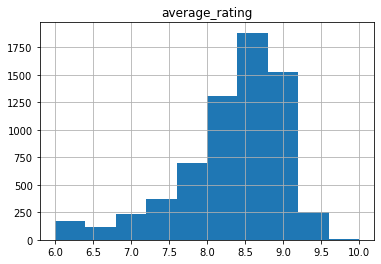

In [35]:
# Gin avergae rating histogram
df_gin.hist(column='average_rating' ,bins=10)

In [36]:
# Most rated gins 
df_gin_explore = df_gin[["name", "rating_count"]]
df_gin_explore.sort_values("rating_count", ascending=False).head(5)

,name,rating_count
1208,Hendrick's Gin,9151
1594,Monkey 47 Schwarzwald Dry Gin,7318
1040,Gin Mare,7022
459,Bombay Sapphire Distilled London Dry Gin,6703
2237,The Botanist,4589


array([[<AxesSubplot:title={'center':'rating_count'}>]], dtype=object)

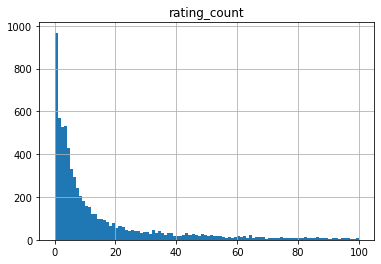

In [37]:
# Gin ratings count histogram
# Most gins have 0-20 ratings
df_gin.hist(column='rating_count' ,bins=100, range=[0, 100])

In [38]:
# Best rated producers
df_gin_explore = df_gin[["producer", "average_rating"]]
df_gin_explore.groupby('producer').mean().sort_values("average_rating",ascending=False).head(3)

,average_rating
producer,
Spitzmund,9.666667
Awardoo UG,9.500000
Norlyk Distillery ApS,9.475000


array([[<AxesSubplot:title={'center':'average_rating'}>]], dtype=object)

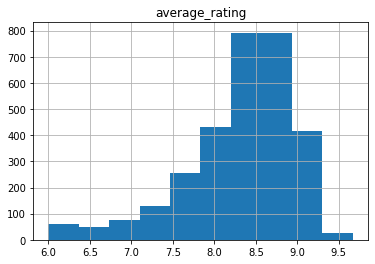

In [39]:
# Producer average ratings histogram
df_gin.groupby('producer').mean().hist(column='average_rating' ,bins=10)

In [40]:
# Countries with the most gins
df_gin.groupby('country').nunique().id.sort_values(ascending=False).head(5)

country
United Kingdom    2398
Germany            964
United States      730
Belgium            547
Spain              489
Name: id, dtype: int64

In [41]:
# Countries with the most gin producers
df_gin.groupby(['country']).nunique().producer.sort_values(ascending=False).head(5)

country
United Kingdom    750
Germany           526
United States     424
Spain             206
France            189
Name: producer, dtype: int64

# AWS

### Redshift setup

In [42]:
# Create role for Redshift to access S3. Start new Redshift cluster and assign S3 access role. Open VPC to access cluster.

roleArn = aws_helper_functions.create_IAM_role_Redshift_to_S3(iam, ROLE_NAME)
aws_helper_functions.create_redshift_cluster(redshift, CLUSTER_ID, CLUSTER_TYPE, 
NODE_TYPE, NUMBER_OF_NODES, DB_NAME, DB_USER, DB_PASSWORD, roleArn)
aws_helper_functions.set_vpc_security_group(redshift, CLUSTER_ID, ec2)

Creating a new IAM Role
Get the IAM role ARN
arn:aws:iam::752709659342:role/DWH_ROLE
Creating new cluster: ginventorydwh
New cluster named 'ginventorydwh' created and available
VPC security group ID: sg-0d5e137166258a0e9
Rule requested already exists


## Load data to Redshift

In [43]:
# Drop and create all tables

response = redshift_data.batch_execute_statement(
        ClusterIdentifier=CLUSTER_ID,
        Database=DB_NAME,
        DbUser=DB_USER,
        Sqls=sql_statements.drop_statements + sql_statements.create_statements
        )


In [44]:
# Load tables from S3
file_names = ['garnishes', 'gins', 'perfect_garnishes', 'perfect_tonics', 'tonics']

# List of S3 imports to execute
sqls = [f"""
        COPY {name}
        FROM 's3://ginventory-bucket/normalized_data/{name}.csv'
        IAM_ROLE '{roleArn}' 
        FORMAT AS csv
        IGNOREHEADER 1
        delimiter ';'
    """ for name in file_names]

response = redshift_data.batch_execute_statement(
    ClusterIdentifier=CLUSTER_ID,
    Database=DB_NAME,
    DbUser=DB_USER,
    Sqls=sqls
    )

# Load countries data from SQL inserts
response = redshift_data.execute_statement(
    ClusterIdentifier=CLUSTER_ID,
    Database=DB_NAME,
    DbUser=DB_USER,
    Sql=sql_statements.INSERT_INTO_COUNTRIES
)


## Data checks, further data modeling

In [45]:
# Check row counts of all tables

for name in file_names:
    sql = f'SELECT COUNT(*) FROM {name}'

    response = redshift_data.execute_statement(
        ClusterIdentifier=CLUSTER_ID,
        Database=DB_NAME,
        DbUser=DB_USER,
        Sql=sql
    )

    print(aws_helper_functions.redshift_get_statement_result_to_dataframe(redshift_data, response['Id']))

   count
0    229
   count
0   7524
   count
0   9641
   count
0   7880
   count
0    675


In [46]:
# Check if all country names adhere to the country table.
# We expect to see 0 rows returned

sql_statement = '''
    SELECT * FROM
    (
        SELECT * FROM gins 
        LEFT JOIN countries 
        ON gins.country = countries.nicename 
        WHERE countries.id is Null
    ) 
        AS country_mismatches;
'''

response = redshift_data.execute_statement(
        ClusterIdentifier=CLUSTER_ID,
        Database=DB_NAME,
        DbUser=DB_USER,
        Sql=sql_statement
    )


aws_helper_functions.redshift_get_statement_result_to_dataframe(redshift_data, response['Id'])

'Result set contains 0 rows.'

In [47]:
# Add country_id column to tonics and gins tables, delete country column.

sqls = []

sqls.append('''
    ALTER TABLE tonics
    ADD country_id smallint;
''')
sqls.append('''
    UPDATE tonics SET country_id = countries.id FROM countries JOIN tonics t on t.country=countries.nicename
''')
sqls.append('''
    ALTER TABLE tonics DROP country
''')

sqls.append('''
    ALTER TABLE gins
    ADD country_id smallint;
''')
sqls.append('''
    UPDATE gins SET country_id = countries.id FROM countries JOIN gins g on g.country=countries.nicename
''')
sqls.append('''
    ALTER TABLE gins DROP country
''')

response = redshift_data.batch_execute_statement(
    ClusterIdentifier=CLUSTER_ID,
    Database=DB_NAME,
    DbUser=DB_USER,
    Sqls=sqls,
)


## Delete Redshift cluster

In [48]:
redshift.delete_cluster( ClusterIdentifier=CLUSTER_ID,  SkipFinalClusterSnapshot=True)

print(f'Deleting cluster: {CLUSTER_ID}')
waiter = redshift.get_waiter('cluster_deleted')
waiter.wait(
        ClusterIdentifier = CLUSTER_ID,
        WaiterConfig = {
            "Delay": 10,
            "MaxAttempts": 30
        }
    )
print(f'{CLUSTER_ID} deleted')

Deleting cluster: ginventorydwh
ginventorydwh deleted


## Delete role

In [49]:
iam.detach_role_policy(RoleName=ROLE_NAME, PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess")
iam.delete_role(RoleName=ROLE_NAME)

{'ResponseMetadata': {'RequestId': '09bd3b88-e1e5-4b91-baa0-ccdbfd7f2c08',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '09bd3b88-e1e5-4b91-baa0-ccdbfd7f2c08',
   'content-type': 'text/xml',
   'content-length': '200',
   'date': 'Thu, 17 Nov 2022 13:04:03 GMT'},
  'RetryAttempts': 0}}